# TASK - 2



#### There are three implementations of task-2 in this jupyter notebook.
**A**: We considered 4 parametrised gates (one layer of R_x and R_y gates on each of the qubits).

**B**: We considered 2 parametrised gates (one layer of R_x and R_y gates on the top qubit).

**C**: BONUS TASK



#### Optimisers Used: COBYLA and SPSA for implementations A and B, and COBYLA and Classical gradient decent method for C.

#### Steps: 
1. We use a customised noise model.
2. We define the layer/layers of R_x and R_y gates.
3. Define a suitable cost-function.
4. Initialise a random array of parameters for the R_x and R_y gates.
5. Use optimisers like COBYLA/SPSA to optimise the cost function.
6. Make another circuit excluding the last two measurements (i.e without the measurement gates on the last mesaurement).
7. Plot Histogram results to display probabilities.
8. And print the final state-vector from the circuit in 6.








## We attempt A first. (USING COBYLA)

#### (I) Importing required libraries

In [1]:


from qiskit import Aer, execute
from qiskit.aqua.components.optimizers import COBYLA, SLSQP, L_BFGS_B, SPSA, AQGD, CG, NFT, ADAM, P_BFGS
import numpy as np
import qiskit.providers.aer.noise as noise
from qiskit import IBMQ
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram
%matplotlib inline

In /home/bhargav/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bhargav/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bhargav/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/bhargav/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/bhargav/anaconda3/lib/python3.7/site-packages/m

#### (II) Defining a custom noise model. 
As the requirements demand that simulations are to be done in presence of noise, we introduce a customised noise model which includes depolarising error, phase damping error and amplitude damping error.

In [2]:
def custom_noise_model(qubits_with_errors: int, dp=0.01, pd=0.091, ad=0.01):
    prob_1 = dp  # 1-qubit gate
    phase_damping_param = pd
    amplitude_damping_param = ad
    error_qubits = list(range(qubits_with_errors))  # error only in first k qubits (the encoding/decoding qubits)

    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)

    # Phase Damping Errors
    error_2 = noise.phase_damping_error(phase_damping_param)

    # amplitude damping errors
    error_3 = noise.amplitude_damping_error(amplitude_damping_param)

    # Add errors to noise model, only to identity gates
    noise_model = noise.NoiseModel()
    for i in error_qubits:
        noise_model.add_quantum_error(error_1, ['id', 'u3'], [i], warnings=False)
        noise_model.add_quantum_error(error_2, ['id', 'u3'], [i], warnings=False)
        noise_model.add_quantum_error(error_3, ['id', 'u3'], [i], warnings=False)
    return noise_model


#### (III) Defined a function for layers consisting of  R_x, R_y gates.

In [3]:
def rx_ry_layer(params:np.ndarray):
    qc = QuantumCircuit(2)
    qc.rx(params[0], 0)
    qc.ry(params[0], 0)
    #qc.i(1)
    #qc.rx(np.pi,1)
    #qc.rx(np.pi,1)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    return qc

#### (IV) Defined a function for CNOT and measurements.

In [4]:
def cirq(params:np.ndarray):
    qc = rx_ry_layer(params)
    qc.cx(0, 1)
    qc.measure_all()
    return qc

#### (V) Defined a function for Cost Function.
#### 1. Tried for:  number of shots of measurements / iteration = 1 using COBYLA.






In [146]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=1, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

#### (VI) Initialised a random array of parameters, optimised using COBYLA and printed the final circuit.


[ 0.38383624 -0.29125569 -0.25588319  0.97582075]
(array([ 1.41708085,  0.70765772, -0.0076275 ,  0.96145162]), 0.022099999999999995, 47)
        ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(1.4171) ├──■───░─┤M├───
        └─┬────────┬─┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ──┤ RX(pi) ├──┤ X ├─░──╫─┤M├
          └────────┘  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════╩══╩═
                               0  1 


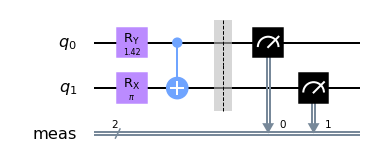

In [195]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))
final_cirq.draw('mpl')


####  (VII ) Plotted the histogram results.
#### Used 1 as the no. of shots.

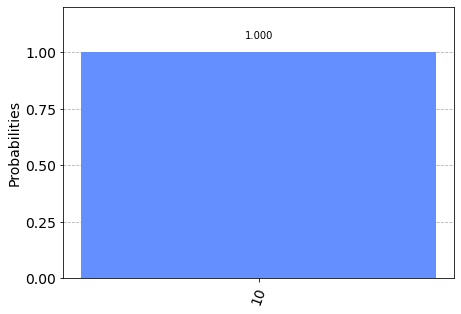

In [196]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=1).result().get_counts()
plot_histogram(counts)



####  ( VIII ) Created a circuit without the measurement gates (for the very last two measurements of the two qubits)
#### to obtain the final state vector.

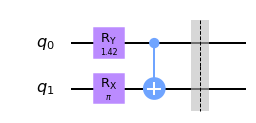

In [197]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')


#### ( IX ) Printed the statevector just before the last two measurements.

In [198]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[4.64944791e-17+0.j         3.98454874e-17-0.65072619j
 4.64944791e-17-0.75931247j 3.98454874e-17+0.j        ]


#### Above tried using COBYLA for 1 shot of measurement per iteration.
#### Tried for 10 shots below.

In [199]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=10, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[ 0.94591684 -0.38595645  1.00433085 -1.21605775]
(array([ 0.94584985, -0.38591551,  1.00438061, -0.21609461]), 0.32000000000000006, 42)
        ┌─────────────┐      ░ ┌─┐   
   q_0: ┤ RY(0.94585) ├──■───░─┤M├───
        └──┬────────┬─┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ───┤ RX(pi) ├──┤ X ├─░──╫─┤M├
           └────────┘  └───┘ ░  ║ └╥┘
meas: 2/════════════════════════╩══╩═
                                0  1 


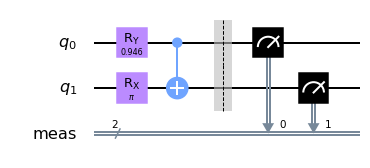

In [200]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))
final_cirq.draw('mpl')


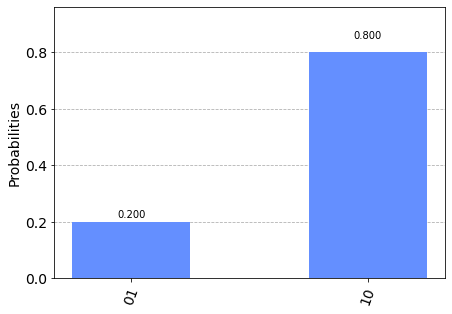

In [201]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=10).result().get_counts()
plot_histogram(counts)



In [202]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[5.45114672e-17+0.j         2.78908479e-17-0.45549211j
 5.45114672e-17-0.89023982j 2.78908479e-17+0.j        ]


#### Above tried using COBYLA for 10 shots of measurement per iteration.
#### Below for 100 shots

In [203]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=100, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[-0.23975438  1.4068472  -0.40617642 -0.00809147]
(array([ 1.40578983,  2.6466628 , -0.70257991,  1.49688498]), 0.01809999999999999, 47)
        ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(1.4058) ├──■───░─┤M├───
        └─┬────────┬─┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ──┤ RX(pi) ├──┤ X ├─░──╫─┤M├
          └────────┘  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════╩══╩═
                               0  1 


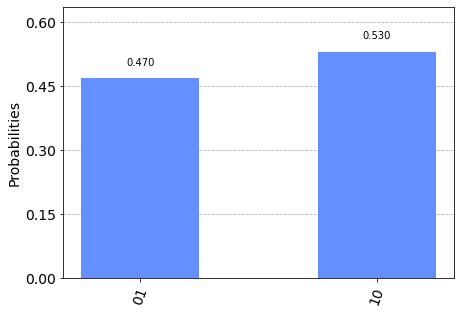

In [205]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=100).result().get_counts()
plot_histogram(counts)




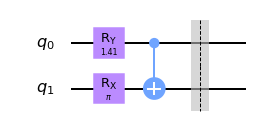

In [206]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')




In [17]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()
print(statevector)

[ 0.14346554+0.j          0.0012488 +0.68583689j -0.69286243-0.09590344j
 -0.0195408 -0.13930605j]


#### Above tried using COBYLA for 100 shot of measurement per iteration.
#### Below for 1000 shots

In [18]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=1000, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[ 0.75860346  1.46767032 -2.57601328 -2.63303449]
(array([ 1.58833482,  1.96201415, -0.13341685, -3.09656144]), 0.00033300000000000056, 55)
         ┌────────────┐  ┌────────────┐      ░ ┌─┐   
   q_0: ─┤ RX(1.5883) ├──┤ RY(1.5883) ├──■───░─┤M├───
        ┌┴────────────┴┐┌┴────────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RX(-0.13342) ├┤ RY(-3.0966) ├┤ X ├─░──╫─┤M├
        └──────────────┘└─────────────┘└───┘ ░  ║ └╥┘
meas: 2/════════════════════════════════════════╩══╩═
                                                0  1 


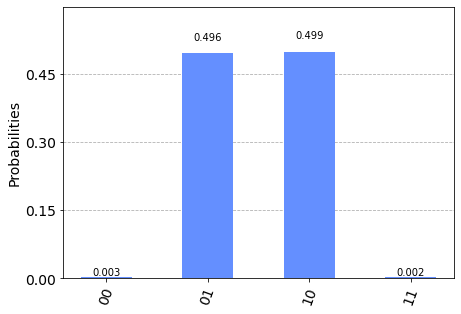

In [19]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=1000).result().get_counts()
plot_histogram(counts)


In [20]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)


[ 0.04973581+0.j          0.67246963+0.21250571j -0.22433371+0.66884566j
 -0.00087184-0.04971287j]


### Optional : Above tried using COBYLA for 1000 shot of measurement per iteration.
### Tried for 65536 shots below.

In [143]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=65536, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[ 0.53274249 -0.20846064 -0.9971442  -0.25131205]
(array([ 1.57484797,  0.80388398, -1.00151946, -0.25239541]), 0.00019069225527346134, 51)
        ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(1.5748) ├──■───░─┤M├───
        └─┬────────┬─┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ──┤ RX(pi) ├──┤ X ├─░──╫─┤M├
          └────────┘  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════╩══╩═
                               0  1 


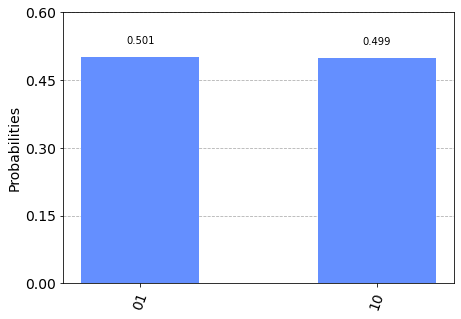

In [144]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=65536).result().get_counts()
plot_histogram(counts)


In [145]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
#sans_measurements.draw('mpl')
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)



[4.32100004e-17+0.j         4.33854275e-17-0.7085378j
 4.32100004e-17-0.70567286j 4.33854275e-17+0.j        ]


#### RESULTS 1 :  
We observe that as we increase the no. of shots from 1 to 10 to 100 and eventually to 1000 and 65536, the desired probabilities (equal prob for |01> and |10>) occured more accurately even in presence of noise.
As we observed for **1 shot**, we just get the state 10 (with 100% prob), and when we increased it to **10 shots**, the probabilities became 20% and 80% respectively (better than 1 shot). 
And upon increasing it to 100 and ultimately 1000 and 65536 shots, we observed the probabilities improved significantly (almost 50 percent each for |01> and |10>) as required). Also, the statevectors have relative phases in them, i.e, the statevectors we get for 1000 shots (where our desired probabilities are achieved) are of the form |01> + e(i*phi)|10>, where phi is non-zero. 

## We Attempt A again using SPSA optimiser now
### For 10 shots below:

In [24]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=10, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

In [25]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
#opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)


ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))


[-1.81749328  0.17393514 -0.64516695  0.30962782]
(array([-1.49799362,  0.76280062, -2.68101449,  0.0956305 ]), 0.009999999999999995, None)
        ┌────────────┐ ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RX(-1.498) ├─┤ RY(-1.498) ├──■───░─┤M├───
        ├────────────┤┌┴────────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RX(-2.681) ├┤ RY(0.09563) ├┤ X ├─░──╫─┤M├
        └────────────┘└─────────────┘└───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════════════╩══╩═
                                              0  1 


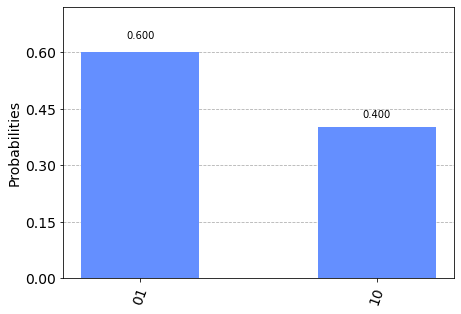

In [26]:
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=10).result().get_counts()
plot_histogram(counts)



## FOR 100 shots below:

In [28]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=100, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

In [29]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
#opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)


ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))


[ 1.62248425 -1.13889198 -2.00146029  0.42022558]
(array([ 1.56998994, -1.1530896 , -3.05660085, -0.03903434]), 0.0162, None)
          ┌──────────┐    ┌──────────┐        ░ ┌─┐   
   q_0: ──┤ RX(1.57) ├────┤ RY(1.57) ├────■───░─┤M├───
        ┌─┴──────────┴┐┌──┴──────────┴─┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RX(-3.0566) ├┤ RY(-0.039034) ├┤ X ├─░──╫─┤M├
        └─────────────┘└───────────────┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════════════════╩══╩═
                                                 0  1 


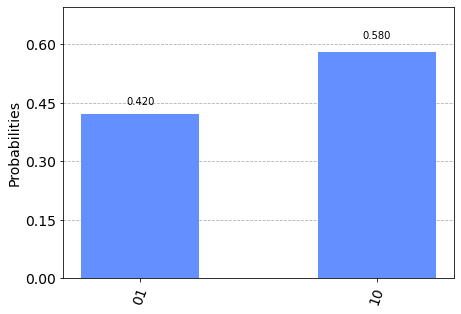

In [30]:
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=100).result().get_counts()
plot_histogram(counts)


## FOR 1000 shots below:

In [32]:
def cost_func(params):
    qc = cirq(params)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=1000, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

In [33]:
param = np.random.randn(4)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
#opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)


ret = opt.optimize(num_vars=4, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
#final_cirq2 = finalcirq.append(x(1))

[-1.48111008  0.64982468  0.72983308 -0.18955962]
(array([-1.50811584, -0.60527137,  0.16882833, -2.91822622]), 0.001999999999999999, None)
        ┌─────────────┐┌─────────────┐      ░ ┌─┐   
   q_0: ┤ RX(-1.5081) ├┤ RY(-1.5081) ├──■───░─┤M├───
        ├─────────────┤├─────────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ RX(0.16883) ├┤ RY(-2.9182) ├┤ X ├─░──╫─┤M├
        └─────────────┘└─────────────┘└───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════╩══╩═
                                               0  1 


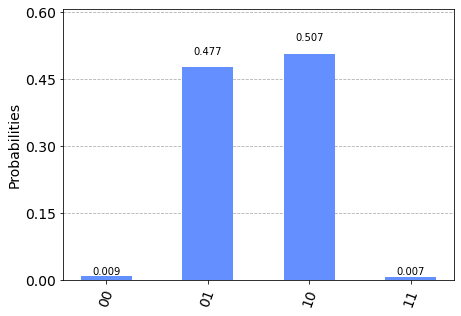

In [34]:
final_cirq.draw('mpl')
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend,shots=1000).result().get_counts()
plot_histogram(counts)


### Results 2: 
The results using SPSA are also quite similar in nature to the results achieved using COBYLA (i.e RESULT 1).

## We attempt B now. (USING COBYLA)

#### (III) Defining a function for only one layer consisting of a  R_x and a  R_y gate

In [213]:
def rx_ry_layer(params:np.ndarray):
    qc = QuantumCircuit(2)
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(np.pi,0)
    #qc.i(1)
 
    #qc.rx(params[2], 1)
    #qc.ry(params[3], 1)
    return qc

#### (IV) Defined a function for CNOT and measurements. 
#### NOTE: Used a reverse CNOT ,by clubbing CNOT with two R_x=pi gates on both sides (reverse CNOT meaning - when control bit is 0, the target bit gets flipped AS OPPOSED to "when control bit is 1, the target bit gets flipped for a traditional CNOT gate" ).

In [214]:
def cirq(params:np.ndarray):
    qc = rx_ry_layer(params)
    qc.cx(0, 1)
    #qc.x(0)
    qc.rx(np.pi,0)
    qc.measure_all()
    return qc
#qc.draw('mpl')

#### (V) Defined a function for Cost Function.

In [215]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=1, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

#### (VI) Initialised a random array of parameters, optimised using COBYLA and printed the final circuit.


[ 1.83702129 -0.1267582 ]
(array([ 1.83702129, -0.1267582 ]), 0.5, 13)
        ┌───────────┐┌──────────────┐┌────────┐     ┌────────┐ ░ ┌─┐   
   q_0: ┤ RX(1.837) ├┤ RY(-0.12676) ├┤ RX(pi) ├──■──┤ RX(pi) ├─░─┤M├───
        └───────────┘└──────────────┘└────────┘┌─┴─┐└────────┘ ░ └╥┘┌─┐
   q_1: ───────────────────────────────────────┤ X ├───────────░──╫─┤M├
                                               └───┘           ░  ║ └╥┘
meas: 2/══════════════════════════════════════════════════════════╩══╩═
                                                                  0  1 


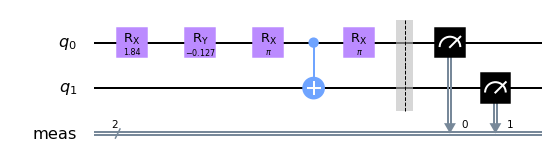

In [216]:
param = np.random.randn(2)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=2, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
final_cirq.draw('mpl')

####  (VII ) Plotted the histogram results.
Used 1 as the no. of shots.

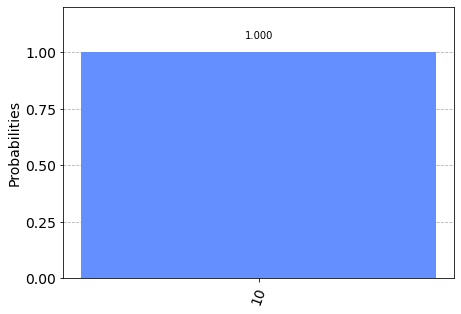

In [217]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=1).result().get_counts()
plot_histogram(counts)


####  (VII )Created the final circuit without the measurement gates to obtain state vector

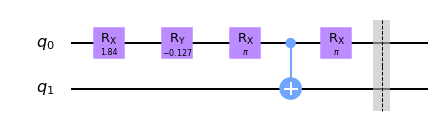

In [218]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')

#### (VIII) Printed the statevector just before the last two measurements.

In [219]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[4.86205693e-17+0.00000000e+00j 4.86205693e-17-7.94034155e-01j
 6.07512247e-01-2.09435205e-02j 1.28242077e-18+3.71993964e-17j]


#### Above tried using COBYLA for 1 shot of measurement per iteration.
#### Below for 10 shots

In [54]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=10, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[-1.26377239 -1.00626377]
(array([-0.26382055, -1.00617613]), 0.07999999999999999, 28)
        ┌──────────────┐┌─────────────┐┌────────┐     ┌────────┐ ░ ┌─┐   
   q_0: ┤ RX(-0.26382) ├┤ RY(-1.0062) ├┤ RX(pi) ├──■──┤ RX(pi) ├─░─┤M├───
        └──────────────┘└─────────────┘└────────┘┌─┴─┐└────────┘ ░ └╥┘┌─┐
   q_1: ─────────────────────────────────────────┤ X ├───────────░──╫─┤M├
                                                 └───┘           ░  ║ └╥┘
meas: 2/════════════════════════════════════════════════════════════╩══╩═
                                                                    0  1 


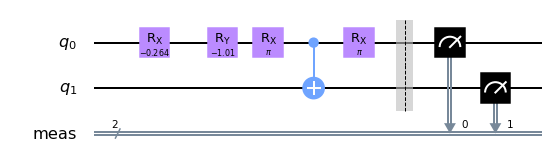

In [55]:
param = np.random.randn(2)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=2, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
final_cirq.draw('mpl')

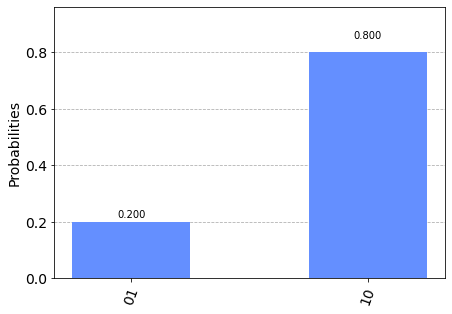

In [56]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=10).result().get_counts()
plot_histogram(counts)


#### Above tried using COBYLA for 10 shot of measurement per iteration.
#### Below for 100 shots

In [59]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=100, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[-0.22534202 -0.30626121]
(array([1.38244295, 1.38771133]), 0.006100000000000005, 30)
        ┌────────────┐┌────────────┐┌────────┐     ┌────────┐ ░ ┌─┐   
   q_0: ┤ RX(1.3824) ├┤ RY(1.3877) ├┤ RX(pi) ├──■──┤ RX(pi) ├─░─┤M├───
        └────────────┘└────────────┘└────────┘┌─┴─┐└────────┘ ░ └╥┘┌─┐
   q_1: ──────────────────────────────────────┤ X ├───────────░──╫─┤M├
                                              └───┘           ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                 0  1 


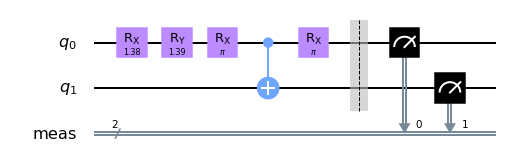

In [60]:
param = np.random.randn(2)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=2, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
final_cirq.draw('mpl')

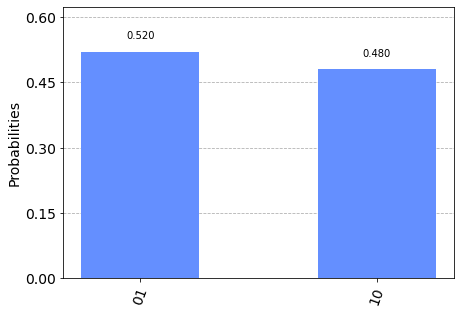

In [61]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=100).result().get_counts()
plot_histogram(counts)

#### Above tried using COBYLA for 100 shot of measurement per iteration.
#### Below for 1000 shots

In [67]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=1000, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[1.10262168 0.80228208]
(array([1.87011782, 1.6253295 ]), 0.0002260000000000004, 31)
        ┌────────────┐┌────────────┐┌────────┐     ┌────────┐ ░ ┌─┐   
   q_0: ┤ RX(1.8701) ├┤ RY(1.6253) ├┤ RX(pi) ├──■──┤ RX(pi) ├─░─┤M├───
        └────────────┘└────────────┘└────────┘┌─┴─┐└────────┘ ░ └╥┘┌─┐
   q_1: ──────────────────────────────────────┤ X ├───────────░──╫─┤M├
                                              └───┘           ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                 0  1 


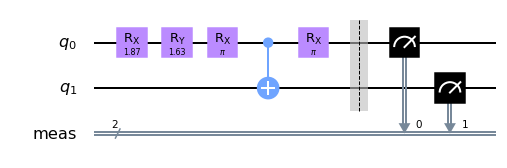

In [68]:
param = np.random.randn(2)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=2, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
final_cirq.draw('mpl')

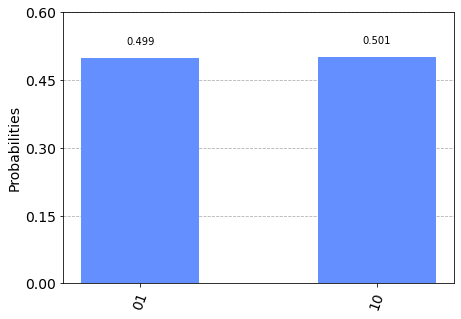

In [69]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=1000).result().get_counts()
plot_histogram(counts)

#### Optional : Above tried using COBYLA for 1000 shots of measurements per iteration.
#### Below for 65536 shots

In [73]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=65536, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[0.03889702 0.37319623]
(array([1.59477421, 1.9262538 ]), 4.235701635479927e-05, 36)
        ┌────────────┐┌────────────┐┌────────┐     ┌────────┐ ░ ┌─┐   
   q_0: ┤ RX(1.5948) ├┤ RY(1.9263) ├┤ RX(pi) ├──■──┤ RX(pi) ├─░─┤M├───
        └────────────┘└────────────┘└────────┘┌─┴─┐└────────┘ ░ └╥┘┌─┐
   q_1: ──────────────────────────────────────┤ X ├───────────░──╫─┤M├
                                              └───┘           ░  ║ └╥┘
meas: 2/═════════════════════════════════════════════════════════╩══╩═
                                                                 0  1 


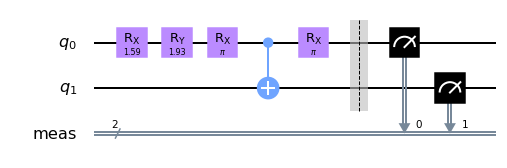

In [74]:
param = np.random.randn(2)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=2, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]
final_cirq = cirq(final_param)
print(final_cirq)
final_cirq.draw('mpl')

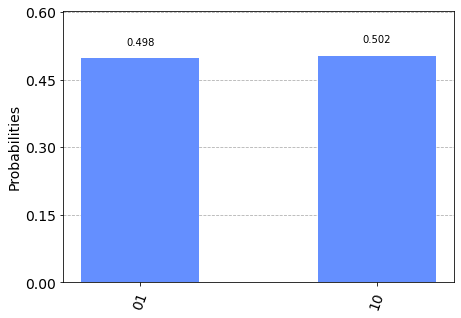

In [76]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=65536).result().get_counts()
plot_histogram(counts)

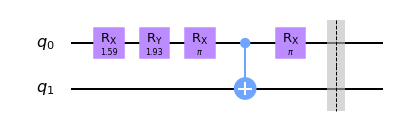

In [77]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')

In [78]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[ 4.31167867e-17+0.00000000e+00j  4.31167867e-17-7.04150564e-01j
  7.09871295e-01+1.59602325e-02j -9.77282380e-19+4.34670804e-17j]


#### RESULTS 3:
The results achieved by using 2 parametrised gates are also quite similar to results achieved by 4 parametrised gates (RESULT 1 using COBYLA and RESULT 2 using SPSA).

## We now attempt the bonus section (USING COBYLA).

In [80]:
def rx_ry_layer(params:np.ndarray):
    qc = QuantumCircuit(2)
    #qc.rx(params[0], 0)
    qc.ry(params[0], 0)
    #qc.i(1)
    qc.rx(np.pi,1)
  
    return qc

In [81]:
def cirq(params:np.ndarray):
    qc = rx_ry_layer(params)
    qc.cx(0, 1)

   
    qc.measure_all()
    return qc
#qc.draw('mpl')

In [125]:
def cost_func(params):
    qc = cirq(params)
    # print(qc)
    noise_model = custom_noise_model(2)
    backend = Aer.get_backend("qasm_simulator")
    result = execute(qc, backend, shots=65536, noise_model=noise_model).result()
    counts = result.get_counts()
    total = sum(counts.values())
    zero_one = counts['01']/total if '01' in set(list(counts.keys())) else 0
    one_zero = counts['10']/total if '10' in set(list(counts.keys())) else 0
    return (0.5-zero_one)**2 + (0.5 - one_zero)**2

[-0.61231202]
(array([-1.58018546]), 0.00011488143354654312, 21)
        ┌────────────┐      ░ ┌─┐   
   q_0: ┤ RY(1.5614) ├──■───░─┤M├───
        └─┬────────┬─┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ──┤ RX(pi) ├──┤ X ├─░──╫─┤M├
          └────────┘  └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════╩══╩═
                               0  1 


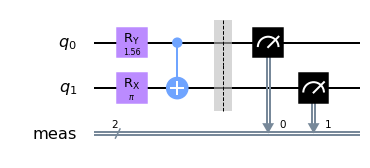

In [126]:

param = np.random.randn(1)
#param=np.random.uniform(0.0,2*np.pi)
print(param)
opt=COBYLA(maxiter=1000, disp=False, rhobeg=1.0, tol=None)
#opt = SPSA(maxiter=1000, save_steps=1, last_avg=1, c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101, c4=0, skip_calibration=False, max_trials=None)
#opt=AQGD(maxiter=200, eta=0.01, tol=0.0000001, disp=True, momentum=0.25)
#opt=ADAM(maxiter=10000, tol=0.0001, lr=0.001, beta_1=0.9, beta_2=0.99, noise_factor=1e-08, eps=1e-10, amsgrad=True, snapshot_dir=None)
ret = opt.optimize(num_vars=1, objective_function=cost_func, initial_point=param)
print(ret)
final_param = ret[0]%(np.pi)
final_cirq = cirq(final_param)



print(final_cirq)
final_cirq.draw('mpl')

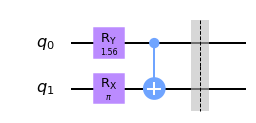

In [127]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = final_cirq.data[:-2]
sans_measurements.draw('mpl')


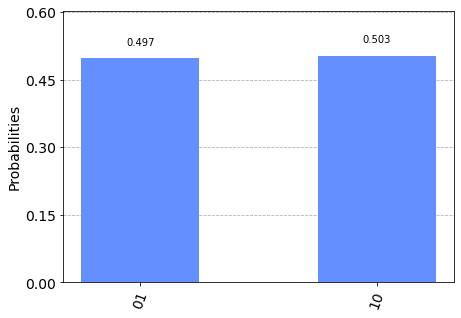

In [128]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(final_cirq, backend, shots=65536).result().get_counts()
plot_histogram(counts)


In [129]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()
print(statevector)



[4.35005893e-17+0.j         4.30940621e-17-0.70377944j
 4.35005893e-17-0.71041854j 4.30940621e-17+0.j        ]


# Results and Explanations (*): 
1. We observe the state vector looks like : ((-i |01> - i |10>)/sqrt(2)). And -i can be treated as a global phase here, so, essentially our statevector |psi> is |01>+|10>/sqrt(2) with no relative phases involved OR
$$
|psi\rangle = \tfrac{-i}{\sqrt{2}}(|01\rangle + |10\rangle)
$$
2. The reason of getting '-i' as a global phase is : 
R_x gate looks like:
$$
R_x(\theta) = \begin{bmatrix} \cos(\theta/2) & -{i}\sin(\theta/2) \\
           -{i}\sin(\theta/2)  & \cos(\theta/2)
     \end{bmatrix}
$$
When $$  \theta=\pi ,$$ we get the matrix : 
$$
R_x(\theta= \pi) = \begin{bmatrix} {0} & -{i} \\
           -{i}  & {0}
     \end{bmatrix}
$$

      Hence, -i comes out as a global phase.

### NOTE: 
  If we use a X gate, in place of R_x=pi gate, we would have got the state :
$$
|psi\rangle = \tfrac{1}{\sqrt{2}}(|01\rangle + |10\rangle)
$$
  with no global phase involved. Statevector |psi> would have looked like this:  (0.        +0.j 0.7082849 +0.j 0.70592669+0.j 0.        +0.j)



## Alternate for the BONUS Part
#### Using a classical gradient using (i) R_x gate , (ii)=X gate     


### (i) Using R_x, R_y and CNOT.

In [130]:
import numpy as np
import math
from random import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state, array_to_latex



In [131]:
theta = np.random.uniform(0.0,2*np.pi)
print("Starting Parameter:",theta)

Starting Parameter: 1.1456626237527596


In [221]:
a = 0.01
while(True):
    #q = QuantumRegister(2)
    #c = ClassicalRegister(2)
    circuit = QuantumCircuit(2)
    circuit.ry(theta,0)
    circuit.rx(np.pi, 1)
    circuit.cx(0,1)
    circuit.measure_all()
    job = execute(circuit, backend, shots=1024)
    probdict = job.result().get_counts(circuit)
   
    #print("theta1 :" ,prob)
    
    prob1 = math.tan(theta/2)*math.tan(theta/2)
    cost = (prob1-1)*(prob1-1)

    if cost <= 0.0001:
        print("Optimal Parameter:",theta)
        break
    dcost = 2*(math.tan(theta/2)*math.tan(theta/2)-1)*math.tan(theta/2)/math.cos(theta/2)/math.cos(theta/2)
    theta = (theta - a*dcost)%(2*np.pi)

Optimal Parameter: 1.5659001765140812


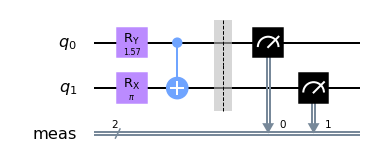

In [222]:
#q = QuantumRegister(2)
#c = ClassicalRegister(2)
circuit = QuantumCircuit(2)
circuit.ry(theta,0)
circuit.rx(np.pi, 1)
circuit.cx(0,1)
circuit.measure_all()
circuit.draw(output='mpl')

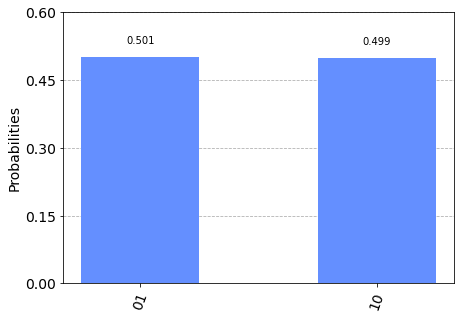

In [223]:
job = execute(circuit, backend, shots=1000)
plot_histogram(job.result().get_counts(circuit))

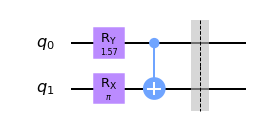

In [224]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = circuit.data[:-2]
sans_measurements.draw('mpl')


In [225]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[4.34036692e-17+0.j         4.31916769e-17-0.70537361j
 4.34036692e-17-0.70883571j 4.31916769e-17+0.j        ]


### ( ii ) Using X gate (special case of R_X gate, since -i*X= R_X(for theta=phi)), R_Y and CNOT gates.

In [226]:
theta = np.random.uniform(0.0,2*np.pi)
print("Starting Parameter:",theta)

Starting Parameter: 3.9720695228435288


In [228]:
a = 0.01
while(True):
    #q = QuantumRegister(2)
    #c = ClassicalRegister(2)
    circuit = QuantumCircuit(2)
    circuit.ry(theta,0)
    circuit.x(1)
    circuit.cx(0,1)
    circuit.measure_all()
    job = execute(circuit, backend, shots=1024)
    probdict = job.result().get_counts(circuit)
   
    #print("theta1 :" ,prob)
    
    prob1 = math.tan(theta/2)*math.tan(theta/2)
    cost = (prob1-1)*(prob1-1)

    if cost <= 0.0001:
        print("Optimal Parameter:",theta)
        break
    dcost = 2*(math.tan(theta/2)*math.tan(theta/2)-1)*math.tan(theta/2)/math.cos(theta/2)/math.cos(theta/2)
    theta = (theta - a*dcost)%(2*np.pi)

Optimal Parameter: 4.717308537525551


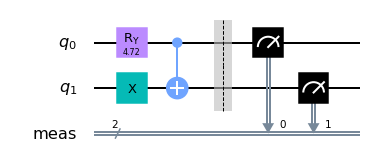

In [231]:
#q = QuantumRegister(2)
#c = ClassicalRegister(2)
circuit = QuantumCircuit(2)
circuit.ry(theta,0)
#circuit.rx(np.pi, 1)
circuit.x(1)
circuit.cx(0,1)
circuit.measure_all()
circuit.draw(output='mpl')

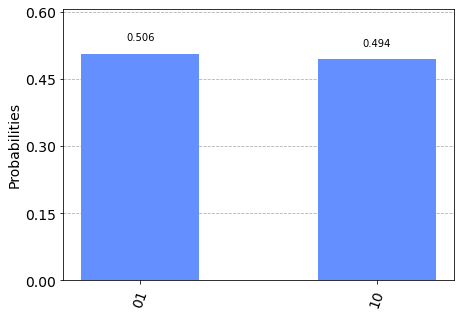

In [232]:
job = execute(circuit, backend, shots=1000)
plot_histogram(job.result().get_counts(circuit))

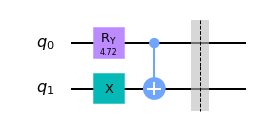

In [233]:
sans_measurements = QuantumCircuit(2)
sans_measurements.data = circuit.data[:-2]
sans_measurements.draw('mpl')


In [234]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(sans_measurements, backend=simulator).result()
statevector = result.get_statevector()

print(statevector)

[-0.        +0.j  0.70536532+0.j -0.70884397+0.j  0.        +0.j]


### RESULTS:
As discussed in Results and Discussions (*), the results are same. 
That is, when we use R_x gate (for theta=pi), we get |psi> as:
$$
|psi\rangle = \tfrac{-i}{\sqrt{2}}(|01\rangle + |10\rangle)
$$
with no relative phases involved (only a global phase -i is observed).

AND when we use X gate which is actually a special case of R_x gate (when theta = pi),then
we get |psi> as :

$$
|psi\rangle = \tfrac{1}{\sqrt{2}}(|01\rangle + |10\rangle)
$$
with no global phases and relative phases involved.